# EMA RSI Strategy

This seems to work best on mean-reverting stocks. Maybe do a test and find the probability of mean reversion?

In [1]:
from datetime import datetime, timedelta
import logging
import pytz
import pandas as pd

from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
import pandas as pd
from talib import ATR, EMA, RSI

from examples.data import (
    download_bars,
    separate_bars_by_symbol,
    split_multi_index_bars_train_test,
)

from bacta.backtester import EventBacktester, Order, Position
from bacta.utilities import dash
from bacta.utilities.logger import get_logger, set_log_level
logger = get_logger()
set_log_level(logging.DEBUG)

/usr/local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class EmaStrategy(EventBacktester):
    """
    Backtester that uses the Keltner Channel to make decisions.
    """

    def __init__(self, active_symbols, cash, **kwargs):
        super().__init__(active_symbols, cash, **kwargs)
        self.short_ema_period = 21
        self.long_ema_period = 200
        self.rsi_period = 14

    def precompute_step(self, bars: pd.DataFrame):
        """
        Preload the indicators for the backtest.
        """

        split_bars = separate_bars_by_symbol(bars)

        self.short_emas = {
            symbol: EMA(
                split_bars[symbol].loc[:,
                                       "close"], timeperiod=self.short_ema_period
            )
            for symbol in self.active_symbols
        }
        self.long_emas = {
            symbol: EMA(
                split_bars[symbol].loc[:,
                                       "close"], timeperiod=self.long_ema_period
            )
            for symbol in self.active_symbols
        }
        self.rsis = {
            symbol: RSI(split_bars[symbol].loc[:, "close"],
                        timeperiod=self.rsi_period)
            for symbol in self.active_symbols
        }

    def update_step(self, bars: pd.DataFrame, index: pd.Timestamp):
        """
        Update the state of the backtester.
        """
        split_bars = separate_bars_by_symbol(bars)

        self.short_emas = {
            symbol: EMA(
                split_bars[symbol].loc[:,
                                       "close"], timeperiod=self.short_ema_period
            )
            for symbol in self.active_symbols
        }
        self.long_emas = {
            symbol: EMA(
                split_bars[symbol].loc[:,
                                       "close"], timeperiod=self.long_ema_period
            )
            for symbol in self.active_symbols
        }
        self.rsis = {
            symbol: RSI(split_bars[symbol].loc[:, "close"],
                        timeperiod=self.rsi_period)
            for symbol in self.active_symbols
        }

    def generate_orders(self, bar: pd.DataFrame, index: pd.Timestamp) -> list[Order]:
        """
        Make a decision based on the prices.
        """
        close_prices = bar.loc[:, "close"]
        # short ema is 21, long ema is 200
        # rsi is 14
        # if rsi is > 75 and short ema is > long ema, then short
        # if rsi is < 25 and short ema is < long ema, then long
        orders = []
        for symbol in self.active_symbols:
            quantity = round(200 / close_prices[symbol], 4)
            if (
                self.rsis[symbol][index] > 70
                and self.short_emas[symbol][index] > self.long_emas[symbol][index]
            ) and self.get_position(symbol) > -10:
                orders.append(
                    Order(symbol, Position.SHORT,
                          close_prices[symbol], quantity)
                )
            elif (
                self.rsis[symbol][index] < 30
                and self.short_emas[symbol][index] < self.long_emas[symbol][index]
            ) and self.get_position(symbol) < 10:
                orders.append(
                    Order(symbol, Position.LONG,
                          close_prices[symbol], quantity)
                )

        return orders


In [3]:
symbols = ["CMS", "DUK", "AAPL"]

shift = timedelta(days=28)
bars = download_bars(
    symbols,
    start_date=datetime(2024, 1, 1) - shift,
    end_date=datetime(2025, 7, 31) - shift,
    timeframe=TimeFrame(1, TimeFrameUnit.Hour)
)
# split the bars into train and test
train_bars, test_bars = split_multi_index_bars_train_test(
    bars, split_ratio=0.82)

# create the backtester
backtester = EmaStrategy(
    symbols,
    cash=2000,
    allow_short=True,
    allow_overdraft=False,
    min_cash_balance=200,
    min_trade_value=1,
    market_hours_only=True,
    transaction_cost=0.0025,
    transaction_cost_type="percentage",
)

# preload the train bars
backtester.load_train_bars(train_bars)

# run_backtest the backtest
backtester.run_backtest(test_bars)

# plot the order and state history
print(dash("order history"))
print(backtester.get_history())
print(dash("state history"))
print(backtester.get_state_history())

[2025-08-15 00:14:44][DEBUG] Loading data/CMSDUKAAPL_2023-12-04_2025-07-03_1Hour.pkl
[2025-08-15 00:14:44][DEBUG] Initializing backtester with active symbols: ['CMS', 'DUK', 'AAPL'], cash: 2000, allow_short: True, allow_overdraft: False, min_cash_balance: 200, min_trade_value: 1, market_hours_only: True
[2025-08-15 00:14:44][INFO] Train bars have been previously loaded. Concatenating with test bars...
[2025-08-15 00:14:44][INFO] Running backtest over 30152 bars from 2025-03-20 23:00:00-04:00 to 2025-07-02 16:00:00-04:00...
[2025-08-15 00:14:44][DEBUG] Placing LONG 1.7 DUK @ $117.650 + $0.500 TC (2025-03-24 10:00:00-04:00)
[2025-08-15 00:14:45][DEBUG] Placing LONG 1.7049 DUK @ $117.310 + $0.500 TC (2025-03-24 14:00:00-04:00)
[2025-08-15 00:14:45][DEBUG] Placing LONG 1.7079 DUK @ $117.100 + $0.500 TC (2025-03-24 15:00:00-04:00)
[2025-08-15 00:14:45][DEBUG] Placing LONG 1.7079 DUK @ $117.100 + $0.500 TC (2025-03-24 16:00:00-04:00)
[2025-08-15 00:14:45][DEBUG] Placing SHORT 0.9083 AAPL @ $

- order history ----------------------------------------------------------------
                          symbol  position   price  quantity
2025-03-24 10:00:00-04:00    DUK         1  117.65    1.7000
2025-03-24 14:00:00-04:00    DUK         1  117.31    1.7049
2025-03-24 15:00:00-04:00    DUK         1  117.10    1.7079
2025-03-24 16:00:00-04:00    DUK         1  117.10    1.7079
2025-03-24 16:00:00-04:00   AAPL        -1  220.20    0.9083
...                          ...       ...     ...       ...
2025-07-02 14:00:00-04:00   AAPL        -1  212.03    0.9433
2025-07-02 15:00:00-04:00   AAPL        -1  212.17    0.9426
2025-07-02 16:00:00-04:00    CMS         1   69.18   10.1290
2025-07-02 16:00:00-04:00    DUK         1  117.06    2.0535
2025-07-02 16:00:00-04:00   AAPL         1  211.62    6.5020

[190 rows x 4 columns]
- state history ----------------------------------------------------------------
                                  cash  portfolio_value     CMS     DUK  \
0      

In [4]:
# plot the performance
print(dash("performance"))
print(backtester.pretty_format_performance())

- performance ------------------------------------------------------------------
Backtest Performance:
- Return on Investment: 33.26%
- vs. Buy and Hold Return: -2.73%
- Sharpe Ratio: 0.58
- Max Drawdown Percentage: 9.04%

- Start Portfolio Value: $2000.00
- End Portfolio Value: $2665.16
- Min Portfolio Value: $1970.08
- Max Portfolio Value: $2675.82
- Min Cash Balance: $199.51
- Max Cash Balance: $4984.58
- Win Rate: 97.33%

- Number of Orders: 190
- Avg Orders per Day: 1.84
- Number of Winning Trades: 182
- Number of Losing Trades: 5
- Avg Trade Return: 4.08%
- Largest Win: 22.18% ($25.83)
- Largest Loss: -1.78% ($-3.57)
- Max Consecutive Wins: 7
- Max Consecutive Losses: 1

- Trading Period Start: 2025-03-20 23:00:00-04:00
- Trading Period End: 2025-07-02 16:00:00-04:00
- Trading Period Length: 103 days 17:00:00
- Time in Market: 96.59%


plotting...


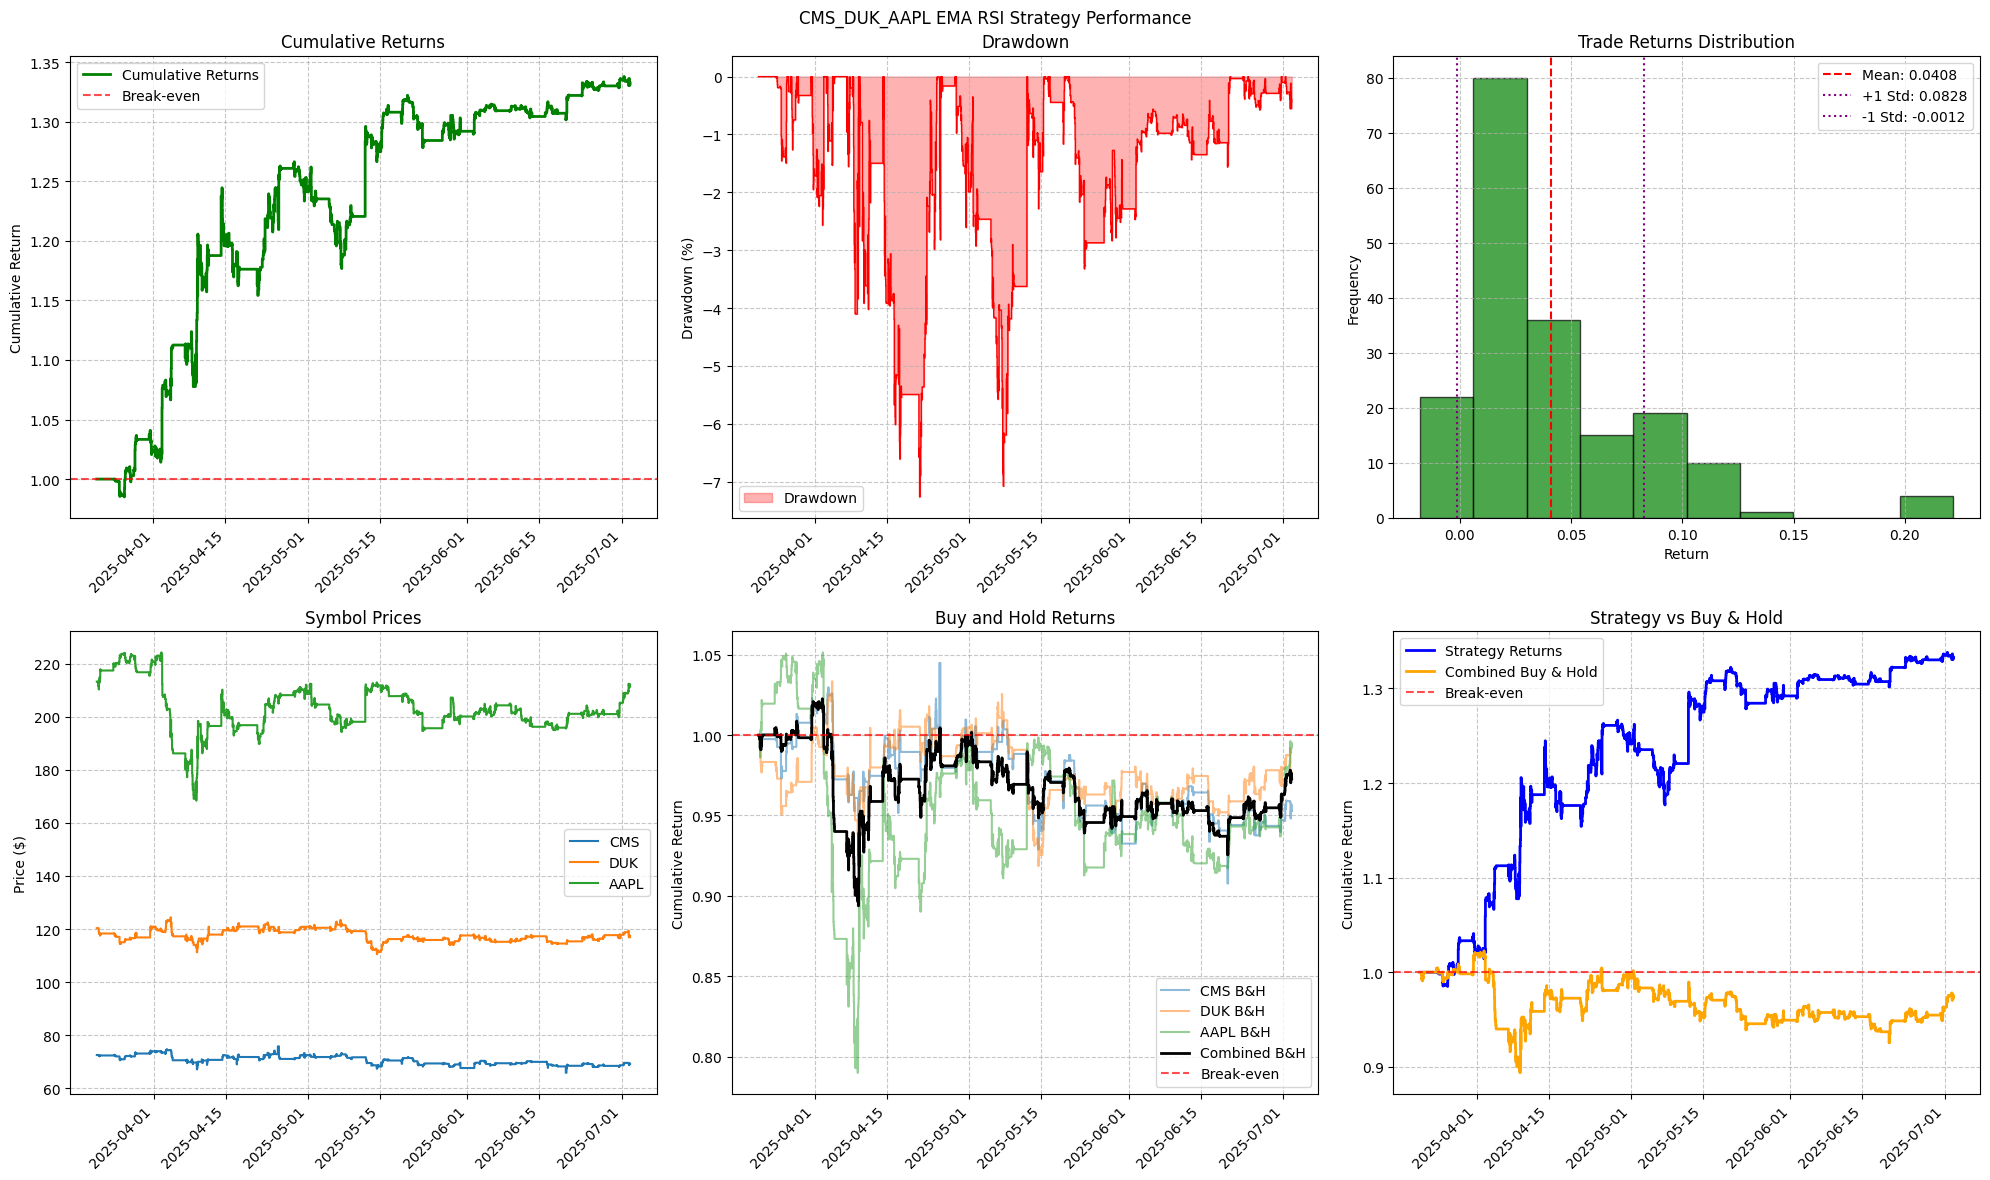

In [5]:
# Plot the results
print("plotting...")
backtester.plot_performance_analysis(
    title="_".join(symbols) + " EMA RSI Strategy Performance", show_plot=False)

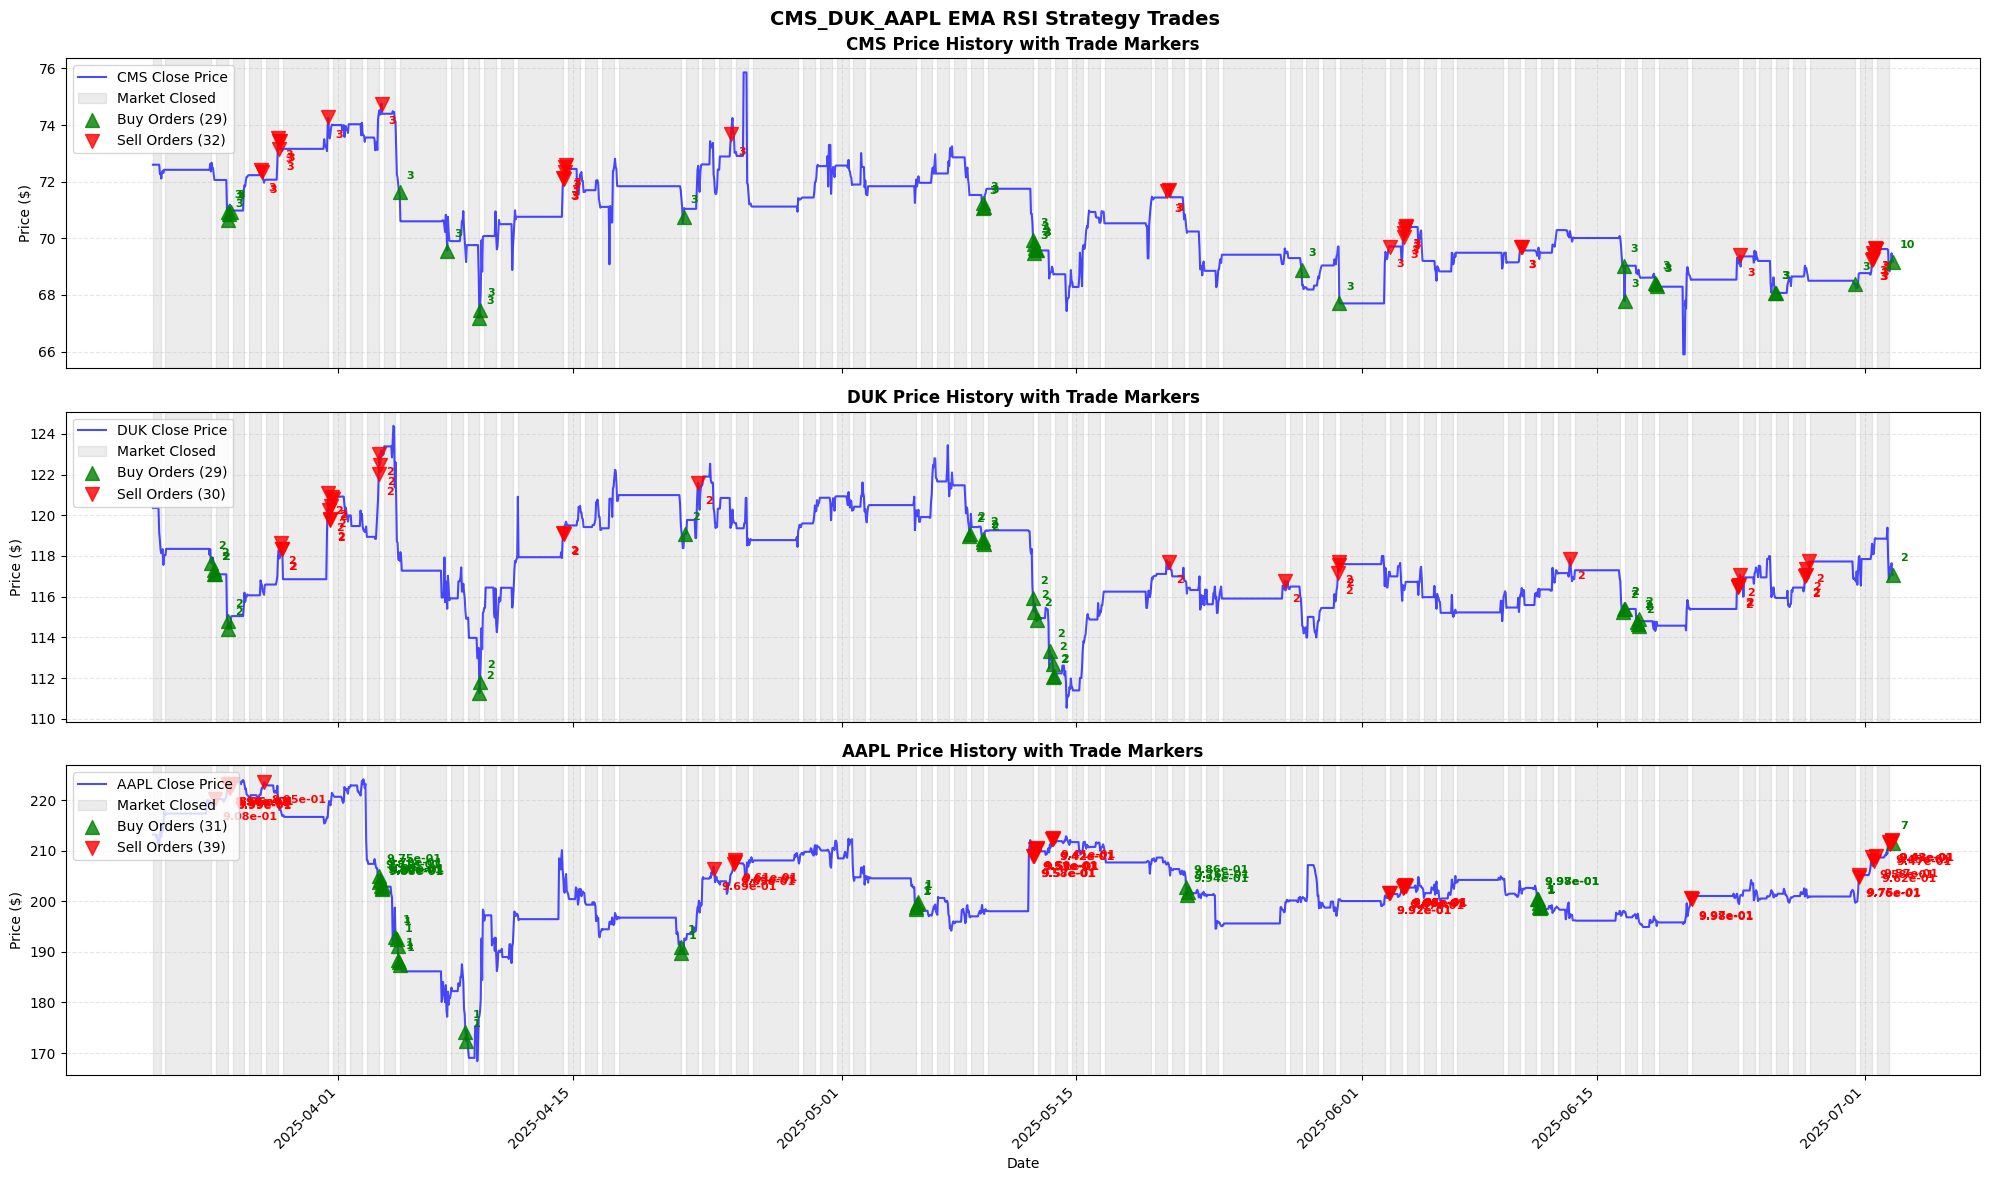

In [6]:
backtester.plot_trade_history(title="_".join(
    symbols) + " EMA RSI Strategy Trades", show_plot=False)

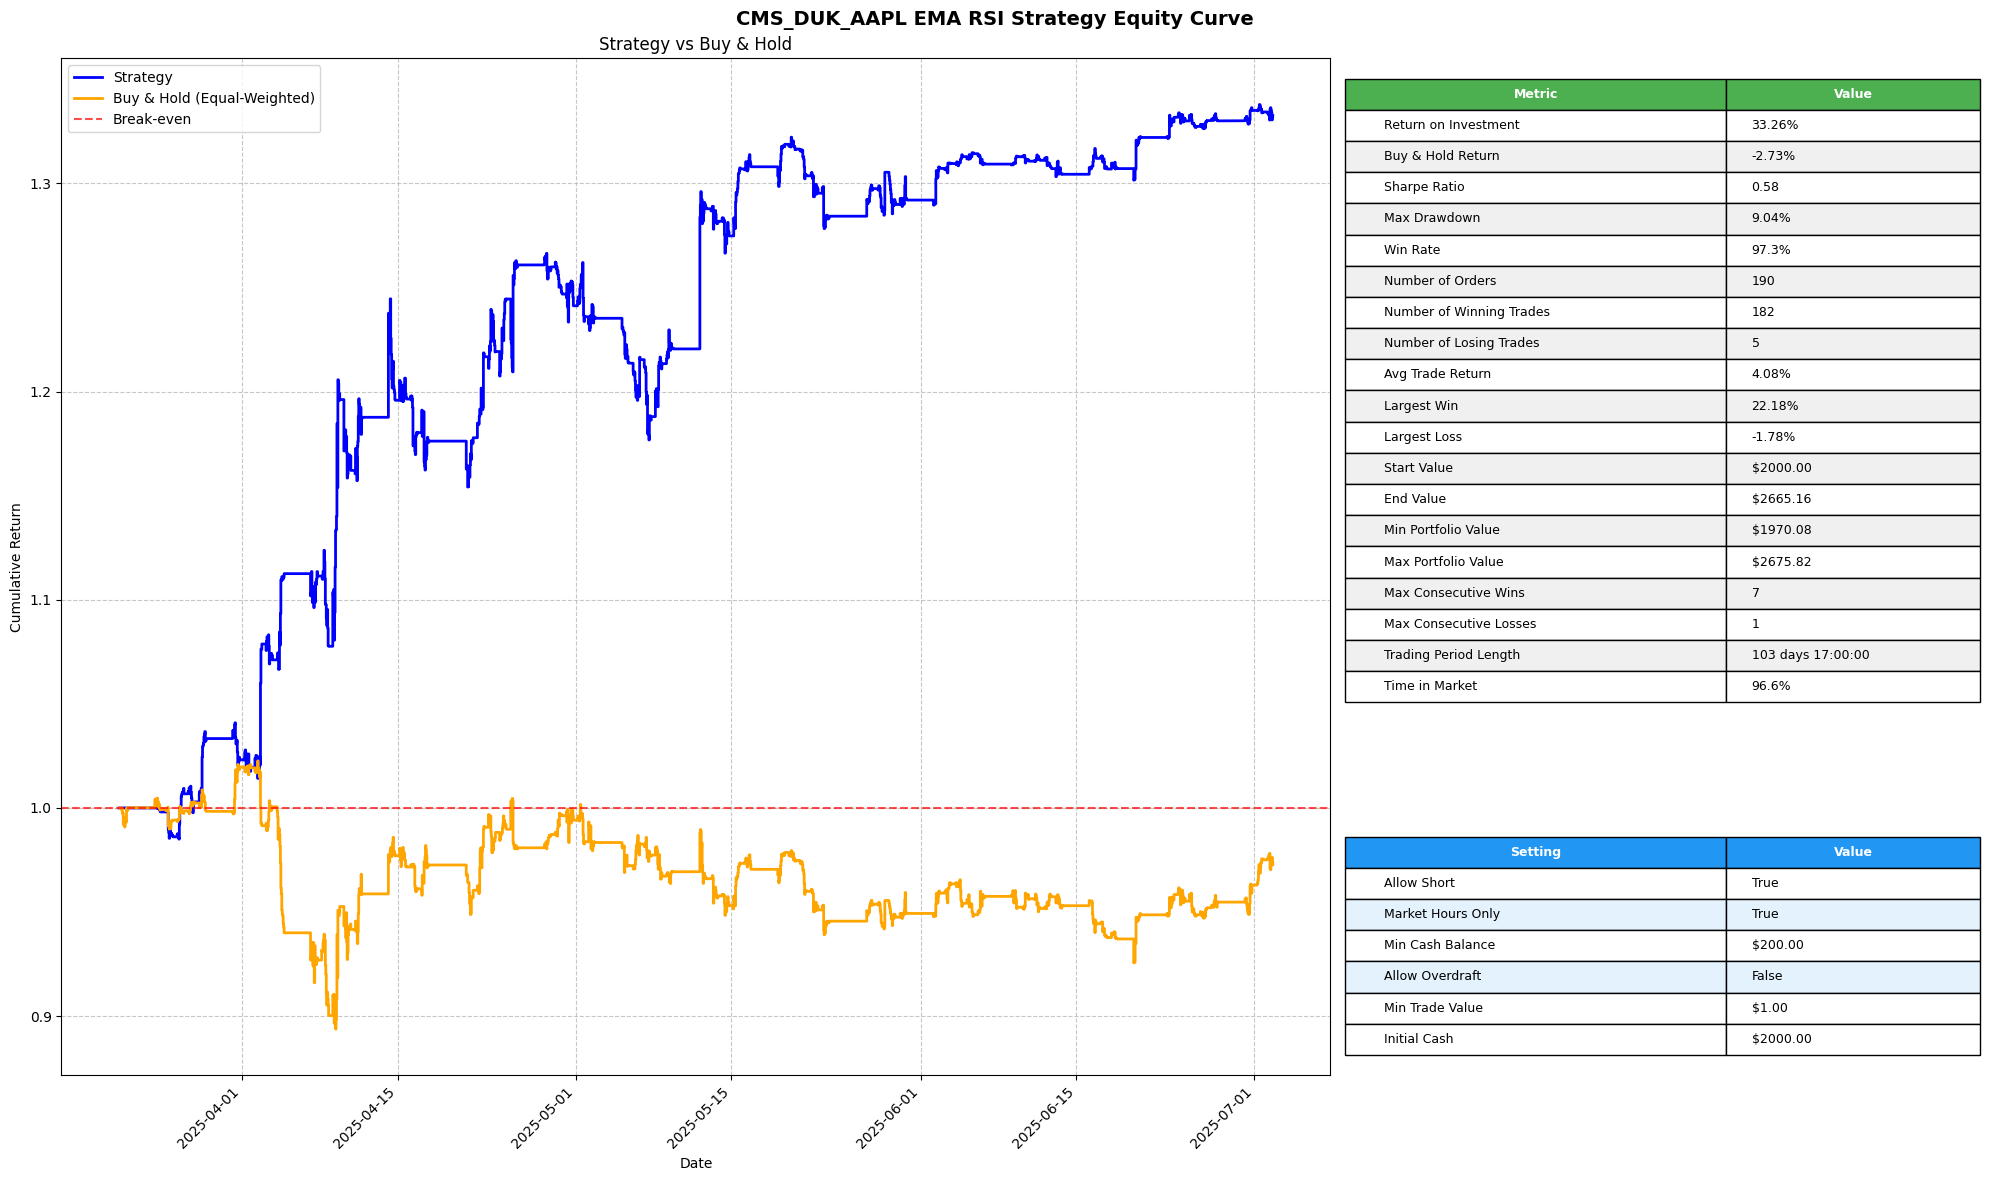

In [7]:
backtester.plot_equity_curve(
    title="_".join(symbols) + " EMA RSI Strategy Equity Curve", show_plot=False
)